<a href="https://colab.research.google.com/github/drsunithaev/cancer_detection/blob/main/brain_tumor_detection_from_mri_images_deep_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <b>1.0 <span style='color:red'>|</span> Import Packages </b> <a class="anchor" id="1.0"></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from tqdm import tqdm

**change directory**

In [ ]:
base_dir  = '/content/drive/MyDrive/Brain'
os.chdir(base_dir)

In [ ]:
my_dir = '/content/drive/MyDrive/Brain'

**get sample dataframe with class labels**

In [ ]:
df = pd.read_csv("Brain Tumor.csv")[['Image', 'Class']]
display(df.head())
print(df.shape)

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


(3762, 2)


# <b>2.0 <span style='color:red'>|</span> Rearrange Images into Training, Validation and Testing </b> <a class="anchor" id="2.0"></a>

**Split files into training, validation and testing. We are using training and validation files when training the model. And we will using testing files to evaluate the final model. <br> Training: 0.8 proportion <br> Validation: 0.1 proportion <br> Testing: 0.1 proportion**

In [ ]:
# Split Training + Validation with Testing Set
def split_size(df, size):
    return int(size * len(df))


train_labels = df['Class'].values[:split_size(df, 0.8)]
train_file_names = df['Image'].values[:split_size(df, 0.8)]

val_labels = df['Class'].values[split_size(df, 0.8):split_size(df, 0.9)]
val_file_names = df['Image'].values[split_size(df, 0.8):split_size(df, 0.9)]

test_labels = df['Class'].values[split_size(df, 0.9):]
test_file_names = df['Image'].values[split_size(df, 0.9):]

In [ ]:
def split_array_labels(arr_image, arr_label):
    arr_image_0 = arr_image[np.where(arr_label==0)]
    arr_image_1 = arr_image[np.where(arr_label==1)]
    return {'0':arr_image_0, '1':arr_image_1}

In [ ]:
train_arr_dict = split_array_labels(train_file_names, train_labels)
val_arr_dict = split_array_labels(val_file_names, val_labels)
test_arr_dict = split_array_labels(test_file_names, test_labels)

**Create empyty directories of training, validation and testing**

In [ ]:
# def create_empty_directories(base_dir):
#     # in case you want to run it several times, delete the directory and create new one
#     check_exist_path = os.path.join(base_dir, '_MODELLING')
#     if os.path.isdir(check_exist_path):
#         shutil.rmtree(check_exist_path)
#         print("Remove old directories")

#     for label in ['0','1']:
#         training_dir = os.path.join(base_dir, '_MODELLING', 'training', label)
#         validation_dir = os.path.join(base_dir, '_MODELLING', 'validation', label)
#         testing_dir = os.path.join(base_dir, '_MODELLING', 'testing', label)



#         os.makedirs(training_dir)
#         os.makedirs(validation_dir)
#         os.makedirs(testing_dir)
#     print(f"Created empty  training, validation and testing directories")
# create_empty_directories(my_dir)

Remove old directories
Created empty  training, validation and testing directories


**Split images by copying and pasting into their respective directories**

In [ ]:
# def split_data(SOURCE_DIR, train_arr_dict, val_arr_dict, test_arr_dict):
#     for label in tqdm(['0','1']):
#         for file_name in train_arr_dict[label]:
#             file_name = f"{file_name}.jpg"
#             source = os.path.join(SOURCE_DIR, '', 'Brain Tumor', file_name)
#             # source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
#             destination = os.path.join(my_dir, '_MODELLING', 'training', label, file_name)
#             copyfile(source, destination)

#         for file_name in val_arr_dict[label]:
#             file_name = f"{file_name}.jpg"
#             source = os.path.join(SOURCE_DIR, '', 'Brain Tumor', file_name)
#             #source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
#             destination = os.path.join(my_dir, '_MODELLING', 'validation', label, file_name)
#             copyfile(source, destination)

#         for file_name in test_arr_dict[label]:
#             file_name = f"{file_name}.jpg"
#             source = os.path.join(SOURCE_DIR, '', 'Brain Tumor', file_name)
#             #source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
#             destination = os.path.join(my_dir, '_MODELLING', 'testing', label, file_name)
#             copyfile(source, destination)
#     print(f"Created training, validation and testing directories containing images")

# split_data(base_dir,train_arr_dict,val_arr_dict,test_arr_dict)

100%|██████████| 2/2 [09:44<00:00, 292.21s/it]

Created training, validation and testing directories containing images


# <b>3.0 <span style='color:red'>|</span> Show Number of Images Per Category Label </b> <a class="anchor" id="3.0"></a>

In [ ]:
base_dir  = my_dir + '/_MODELLING'
os.chdir(base_dir)


In [ ]:

mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))

        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)

pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

,Tran Test,Labels,Number of Items
0,training,0,1822
1,training,1,1187
2,validation,0,119
3,validation,1,257
4,testing,0,138
5,testing,1,239


# <b>4.0 <span style='color:red'>|</span> Show Sample Images of Each Label </b> <a class="anchor" id="4.0"></a>

**Visualising some images of each label**

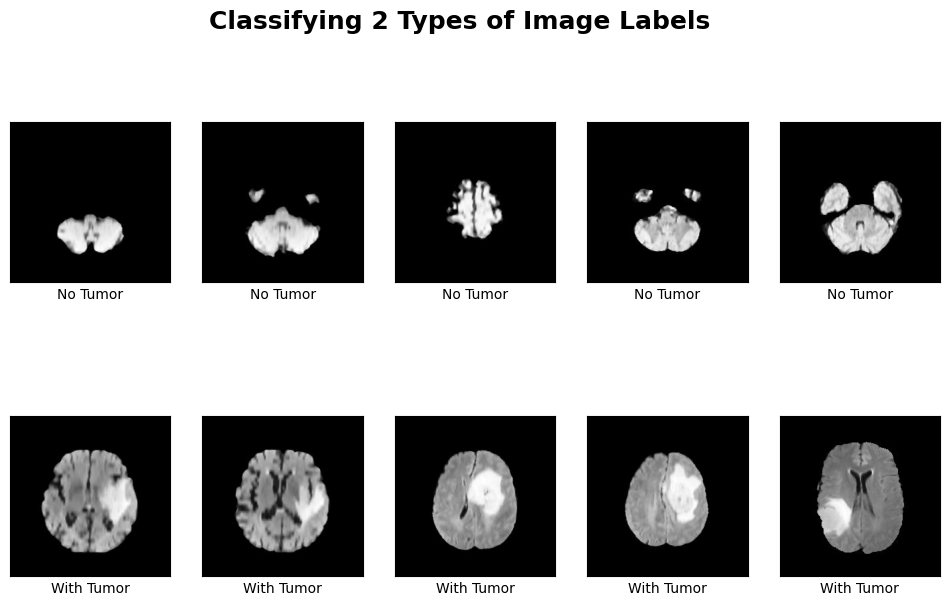

In [ ]:
# # get first 10 images for visualisation
# vis_images = vis_images[:10]
# vis_labels = vis_labels[:10]

# plt.figure(figsize=(12,7))
# for i in range(len(vis_labels)):
#     plt.subplot(2,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     img = mpimg.imread(vis_images[i])
#     plt.imshow(img)

#     if vis_labels[i] == '0':
#         my_label = 'No Tumor'
#     elif vis_labels[i] == '1':
#         my_label = 'With Tumor'

#     plt.xlabel(my_label)
#     plt.suptitle(f"Classifying 2 Types of Image Labels",fontsize=18, fontweight='bold')
# plt.show()

# <b>5.0 <span style='color:red'>|</span> Show Augmented Images, That Can Reduce Overfitting </b> <a class="anchor" id="5.0"></a>

In order to train neural networks that will be used in real-world applications, data augmentation is a crucial step. We can improve our model's ability to generalise and produce more precise predictions on data that it was not trained on by using data augmentation. <br>

Data augmentation will operate concurrently with the other layers of your application on-device and will receive GPU acceleration.

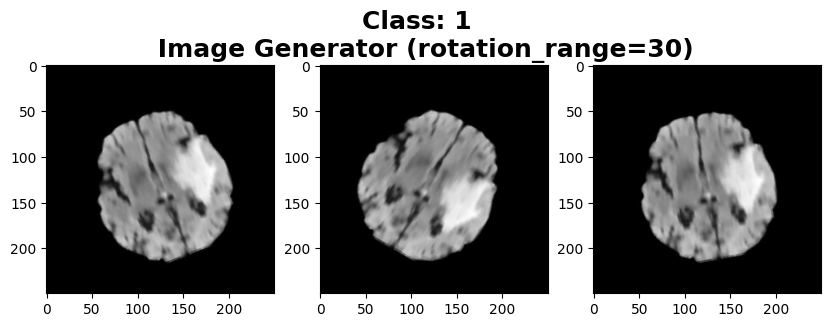

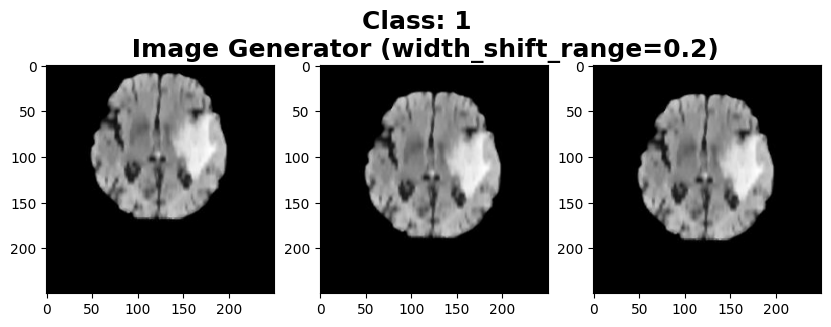

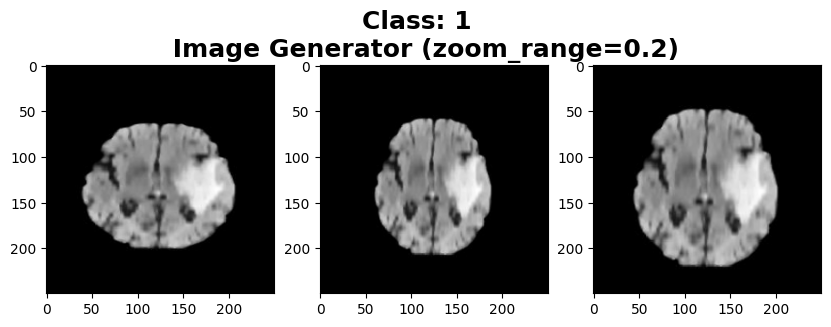

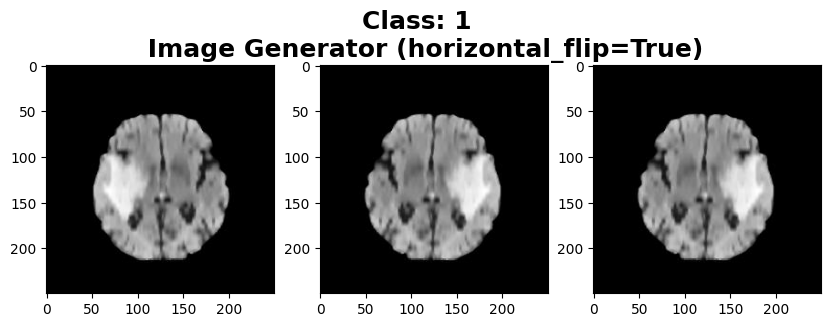

In [ ]:
# def show_ImageDataGenerator(vis_images, vis_labels, image_index):
#     #Loads image in from the set image path
#     class_label = vis_labels[image_index]
#     img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
#     img_tensor = tf.keras.preprocessing.image.img_to_array(img)
#     img_tensor = np.expand_dims(img_tensor, axis=0)

#     #Creates our batch of one image
#     def show_image(datagen, param):
#         pic = datagen.flow(img_tensor, batch_size =1)
#         plt.figure(figsize=(10,3.5))
#         #Plots our figures
#         for i in range(1,4):
#             plt.subplot(1, 3, i)
#             batch = pic.next()
#             image_ = batch[0].astype('uint8')
#             plt.imshow(image_)
#         plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

#         plt.show()

#     datagen = ImageDataGenerator(rotation_range=30)
#     show_image(datagen, "rotation_range=30")

#     datagen = ImageDataGenerator(width_shift_range=0.2)
#     show_image(datagen, "width_shift_range=0.2")

#     datagen = ImageDataGenerator(zoom_range=0.2)
#     show_image(datagen, "zoom_range=0.2")

#     datagen = ImageDataGenerator(horizontal_flip=True)
#     show_image(datagen, "horizontal_flip=True")

# show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)


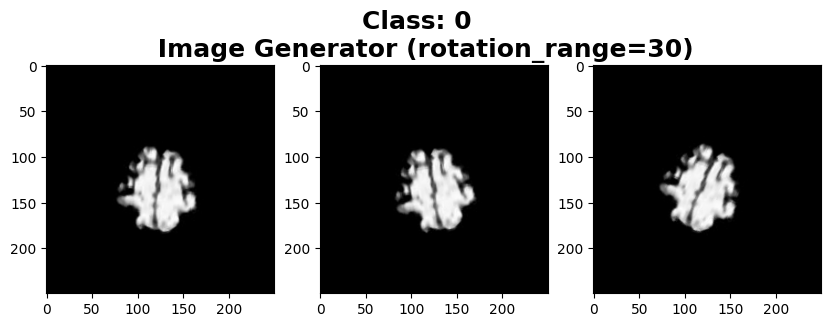

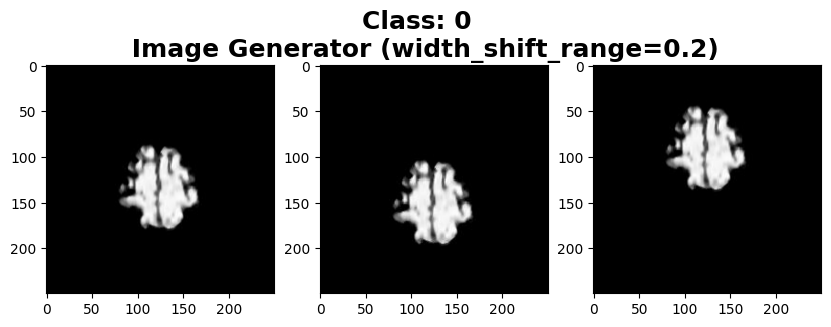

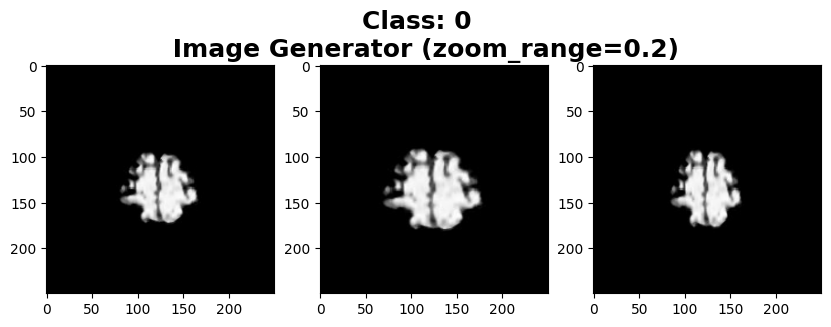

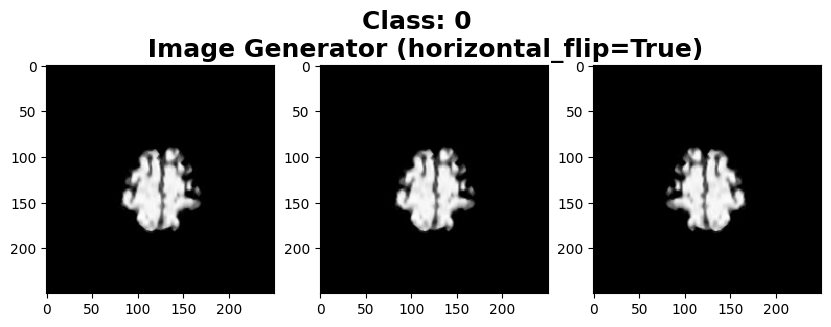

In [ ]:
# show_ImageDataGenerator(vis_images, vis_labels, image_index = 2)

# <b>6.0 <span style='color:red'>|</span> Apply Image Augmentation using Image Data Generator </b> <a class="anchor" id="6.0"></a>

 tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, we can rescale by 1./127.5.

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./127.5,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = valid_or_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

    test_generator = valid_or_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator, test_generator

In [ ]:
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
testing_dir = os.path.join(base_dir, 'testing')

print(testing_dir)

/content/drive/MyDrive/Brain/_MODELLING/testing


In [ ]:
train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, testing_dir)

Found 3009 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


# <b>7.0 <span style='color:red'>|</span> Get Transfer Learning Model - MobileNetV2 </b> <a class="anchor" id="7.0"></a>

MobileNet-v2 is a convolutional neural network consisting of 53 layers deep. The ImageNet database contains a pretrained version of the network that has been trained on more than a million images [1]. The pretrained network can categorise photos into 1000 different object categories. It is good to have a good sense of initialisation of parameters. So we will freeze the top layers of MovileNetV2 first and train on the last output layers.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

9406464/9406464 [==============================] - 0s 0us/step
There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.engine.functional.Functional'>


# <b>8.0 <span style='color:red'>|</span> Building Deep Neural Network Architecture with MobileNetV2 </b> <a class="anchor" id="8.0"></a>

In [ ]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    return model

model = transfer_learning(last_output, base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
model = transfer_learning(last_output, base_model)

print(f"Total Trainable Variables: {len(model.trainable_variables)}")

Total Trainable Variables: 4


This callback will stop the training when there is no improvement in
the validation loss for three consecutive epochs.

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# try this code
model_save_path = my_dir+'/models'
callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                           monitor='val_loss',
                                           save_best_only=True,
                                           verbose=1)
    ]

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[callback])

Epoch 1/10
95/95 [==============================] - ETA: 0s - loss: 1.5608 - accuracy: 0.8185
Epoch 1: val_loss improved from inf to 0.32967, saving model to /content/drive/MyDrive/Brain/models


95/95 [==============================] - 464s 5s/step - loss: 1.5608 - accuracy: 0.8185 - val_loss: 0.3297 - val_accuracy: 0.8617
Epoch 2/10
95/95 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8627
Epoch 2: val_loss did not improve from 0.32967
95/95 [==============================] - 156s 2s/step - loss: 0.3795 - accuracy: 0.8627 - val_loss: 0.3953 - val_accuracy: 0.8484
Epoch 3/10
95/95 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8797
Epoch 3: val_loss improved from 0.32967 to 0.25443, saving model to /content/drive/MyDrive/Brain/models


95/95 [==============================] - 180s 2s/step - loss: 0.3070 - accuracy: 0.8797 - val_loss: 0.2544 - val_accuracy: 0.9016
Epoch 4/10
95/95 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8814
Epoch 4: val_loss did not improve from 0.25443
95/95 [==============================] - 160s 2s/step - loss: 0.2922 - accuracy: 0.8814 - val_loss: 0.3762 - val_accuracy: 0.8537
Epoch 5/10
95/95 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.8840
Epoch 5: val_loss did not improve from 0.25443
95/95 [==============================] - 160s 2s/step - loss: 0.2891 - accuracy: 0.8840 - val_loss: 0.2738 - val_accuracy: 0.8963
Epoch 6/10
95/95 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8850
Epoch 6: val_loss did not improve from 0.25443
95/95 [==============================] - 155s 2s/step - loss: 0.2895 - accuracy: 0.8850 - val_loss: 0.3023 - val_accuracy: 0.8723


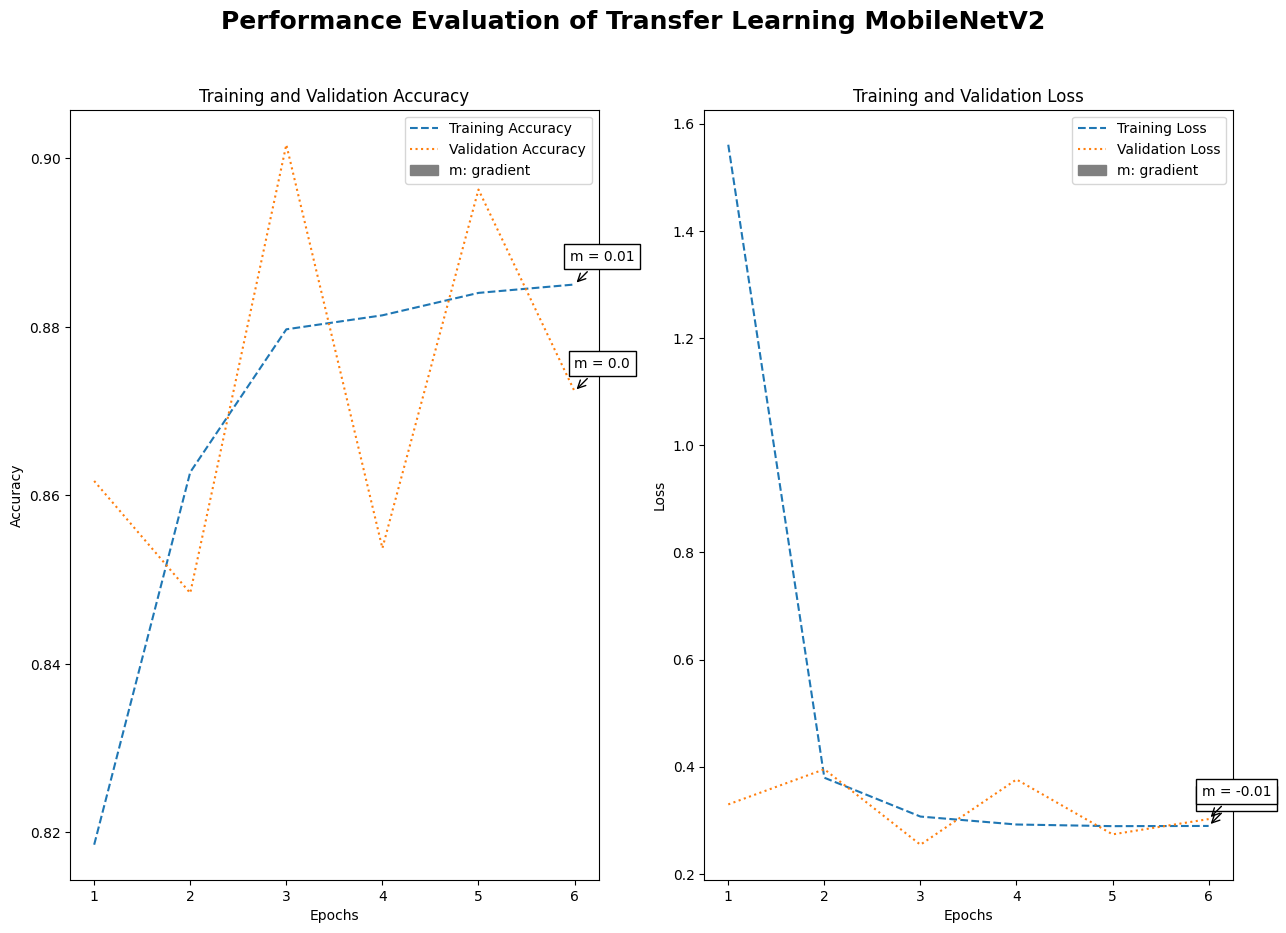

In [ ]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)

        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)

    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()

history_dict_1 = history.history
vis_evaluation(history_dict_1, 'Transfer Learning MobileNetV2')

# <b>9.0 <span style='color:red'>|</span> Fine Tuning Transfer Learning Model </b> <a class="anchor" id="9.0"></a>

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total Trainable Variables: {len(model.trainable_variables)}")

Number of layers in the base model:  154
Total Trainable Variables: 58


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001/10),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_fine = model.fit(train_generator,
                         epochs=15,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 6/15
95/95 [==============================] - 225s 2s/step - loss: 0.5836 - accuracy: 0.8411 - val_loss: 0.3145 - val_accuracy: 0.8617
Epoch 7/15
95/95 [==============================] - 216s 2s/step - loss: 0.3996 - accuracy: 0.8608 - val_loss: 0.3241 - val_accuracy: 0.8697
Epoch 8/15
95/95 [==============================] - 227s 2s/step - loss: 0.3447 - accuracy: 0.8674 - val_loss: 0.3329 - val_accuracy: 0.8723
Epoch 9/15
95/95 [==============================] - 221s 2s/step - loss: 0.3171 - accuracy: 0.8714 - val_loss: 0.3234 - val_accuracy: 0.8856
Epoch 10/15
95/95 [==============================] - 220s 2s/step - loss: 0.3039 - accuracy: 0.8784 - val_loss: 0.3224 - val_accuracy: 0.8910
Epoch 11/15
95/95 [==============================] - 219s 2s/step - loss: 0.2802 - accuracy: 0.8860 - val_loss: 0.3217 - val_accuracy: 0.8910
Epoch 12/15
95/95 [==============================] - 216s 2s/step - loss: 0.2746 - accuracy: 0.8900 - val_loss: 0.3228 - val_accuracy: 0.8803
Epoch 13/1

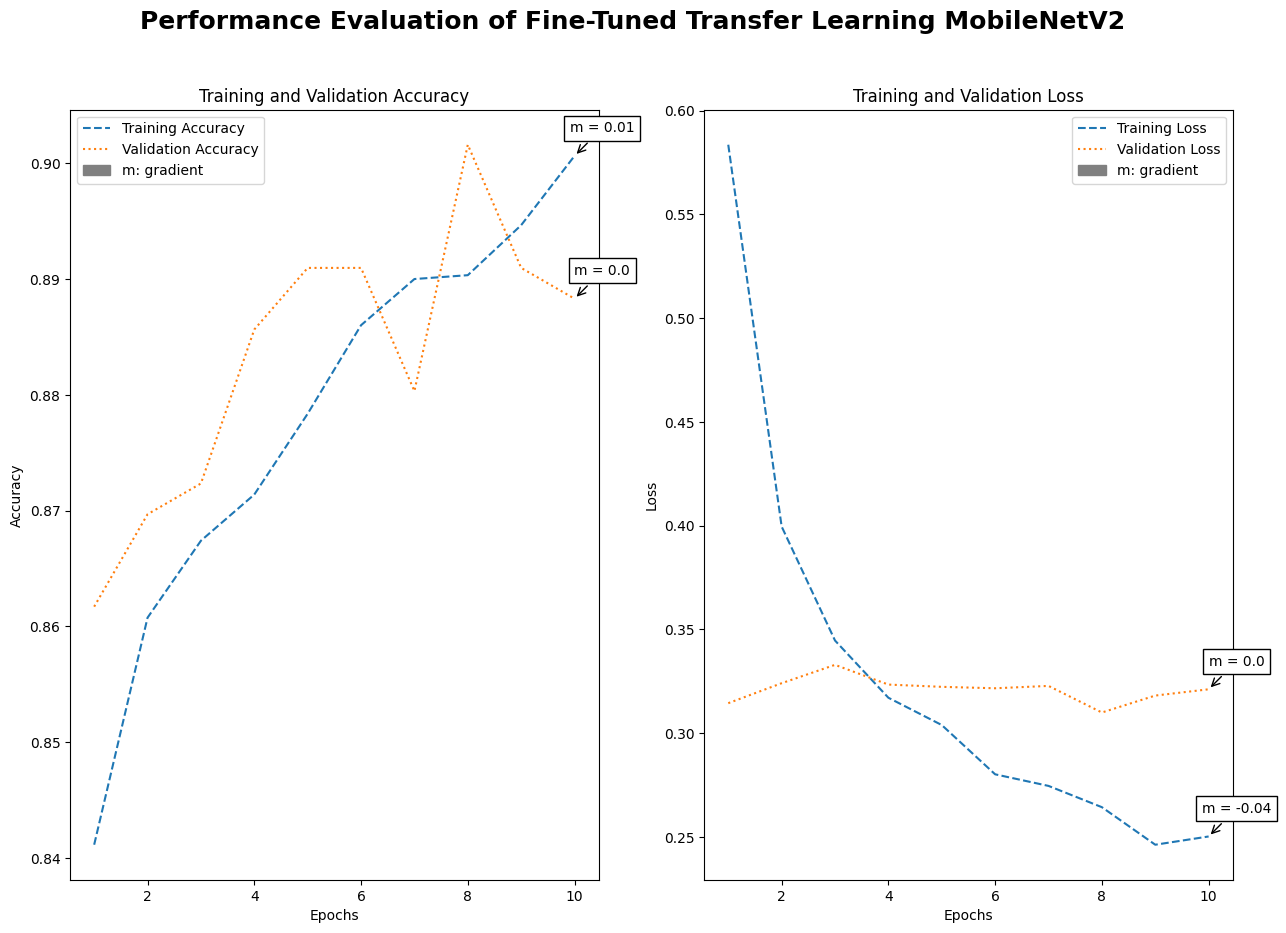

In [ ]:
history_dict_2 = history_fine.history
vis_evaluation(history_dict_2, 'Fine-Tuned Transfer Learning MobileNetV2')

# <b>10.0 <span style='color:red'>|</span> Evaluation on Unseen Data </b> <a class="anchor" id="10.0"></a>

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

12/12 [==============================] - 89s 8s/step - loss: 0.2706 - accuracy: 0.8833
Test accuracy : 0.883289098739624


# <b>11.0 <span style='color:red'>|</span> Visualise Predictions on Unseen Data

In [ ]:
selected_paths = [] ; selected_labels = []
testing_path_0 = os.path.join(base_dir, 'testing', '0')
for x in random.sample(os.listdir(testing_path_0),10):
    selected_paths.append(os.path.join(testing_path_0, x))
    selected_labels.append(0)

testing_path_1 = os.path.join(base_dir, 'testing', '1')
for x in random.sample(os.listdir(testing_path_1),10):
    selected_paths.append(os.path.join(testing_path_1, x))
    selected_labels.append(1)

In [ ]:
X, y = shuffle(selected_paths, selected_labels, random_state=0)

1/1 [==============================] - 2s 2s/step


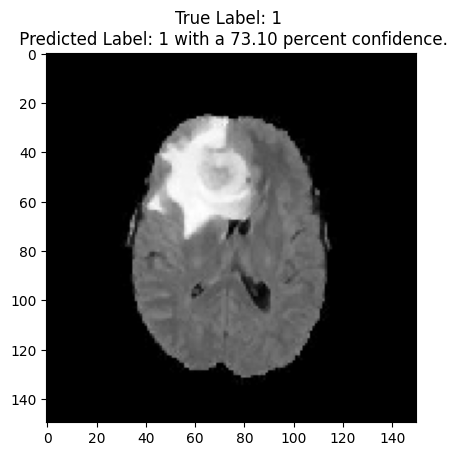

1/1 [==============================] - 0s 63ms/step


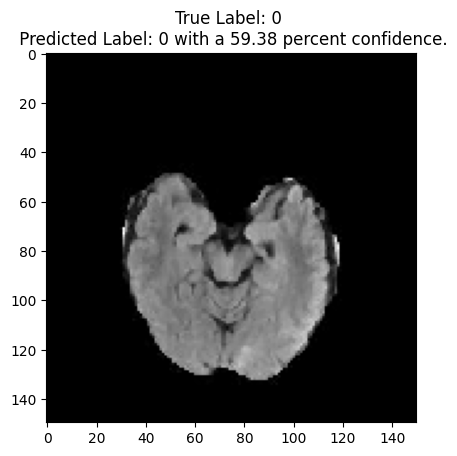

1/1 [==============================] - 0s 62ms/step


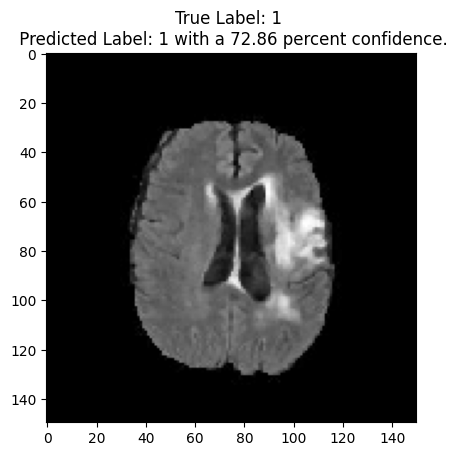

1/1 [==============================] - 0s 60ms/step


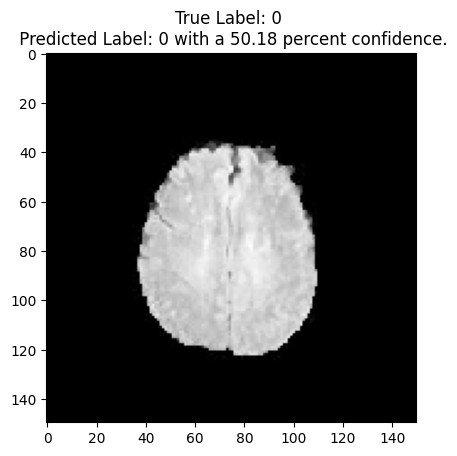

1/1 [==============================] - 0s 58ms/step


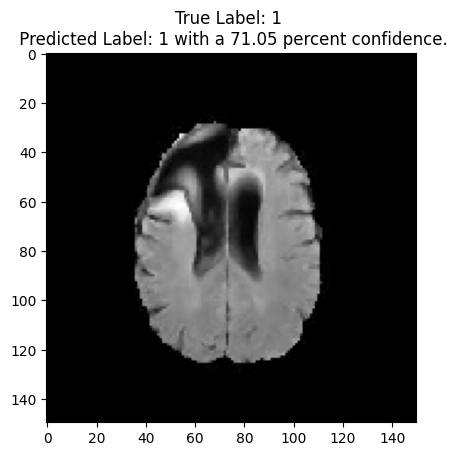

1/1 [==============================] - 0s 57ms/step


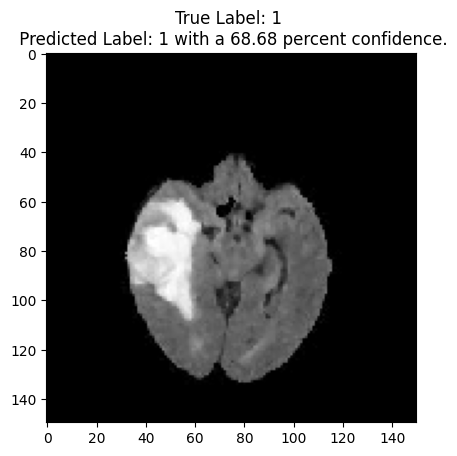

1/1 [==============================] - 0s 59ms/step


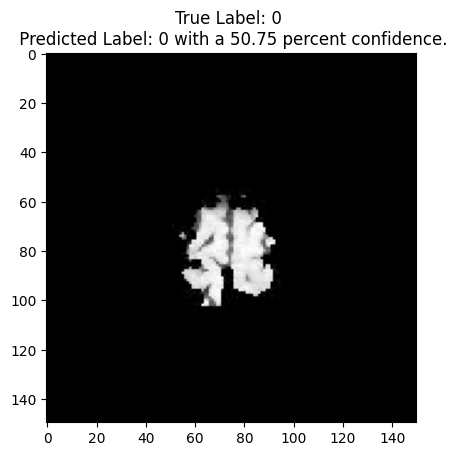

1/1 [==============================] - 0s 58ms/step


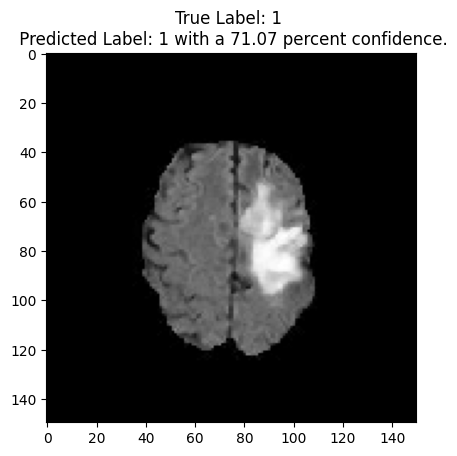

1/1 [==============================] - 0s 63ms/step


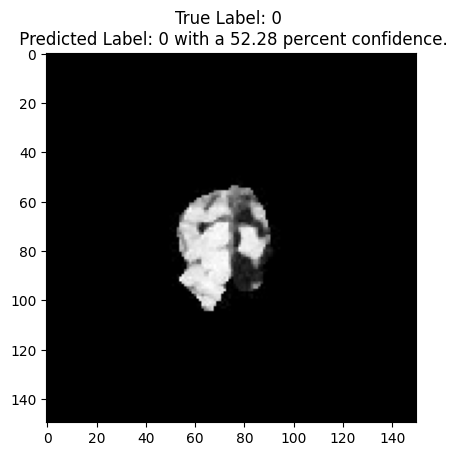

1/1 [==============================] - 0s 58ms/step


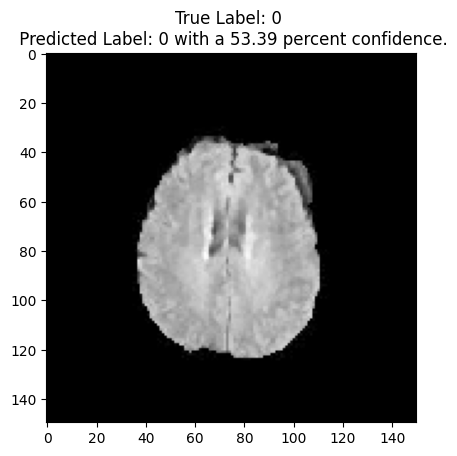

1/1 [==============================] - 0s 61ms/step


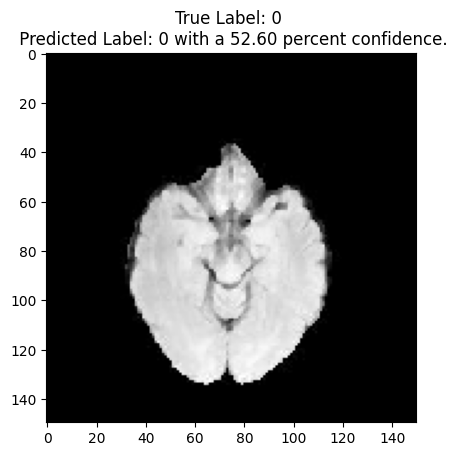

1/1 [==============================] - 0s 58ms/step


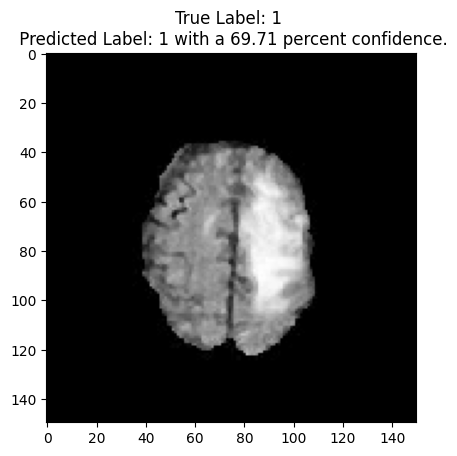

1/1 [==============================] - 0s 58ms/step


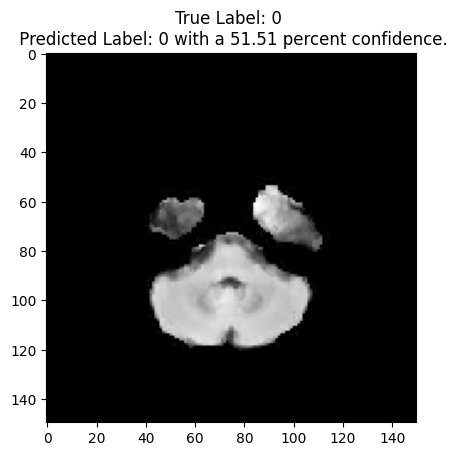

1/1 [==============================] - 0s 70ms/step


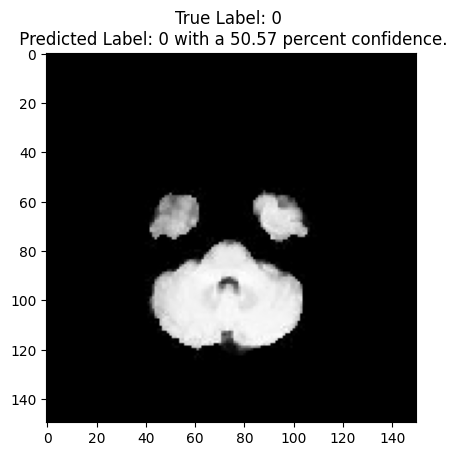

1/1 [==============================] - 0s 58ms/step


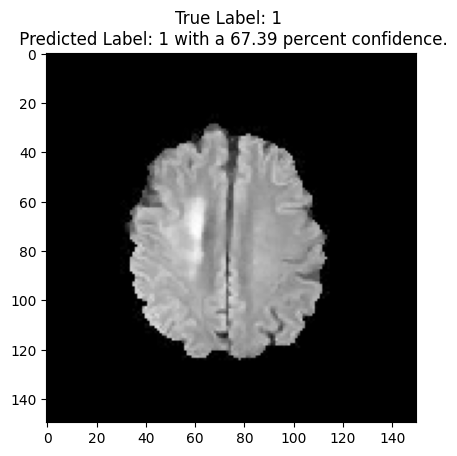

1/1 [==============================] - 0s 70ms/step


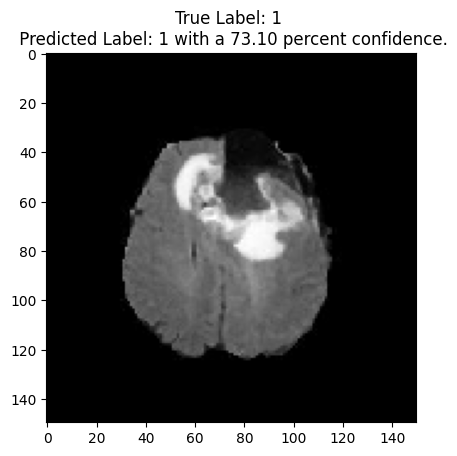

1/1 [==============================] - 0s 69ms/step


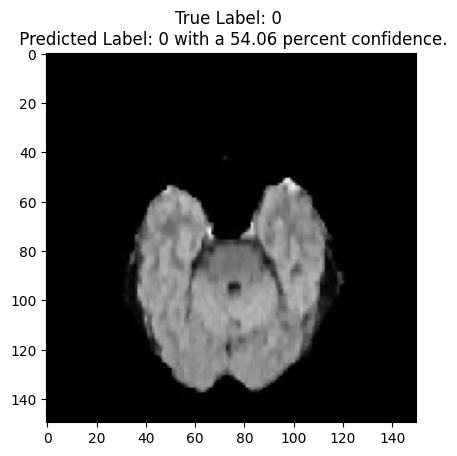

1/1 [==============================] - 0s 78ms/step


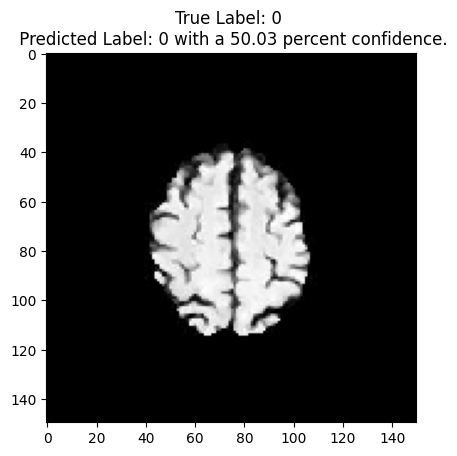

1/1 [==============================] - 0s 73ms/step


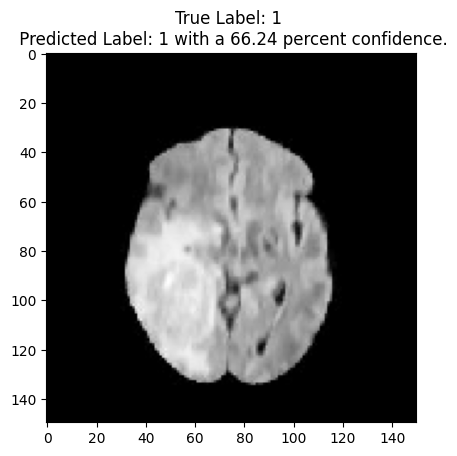

1/1 [==============================] - 0s 68ms/step


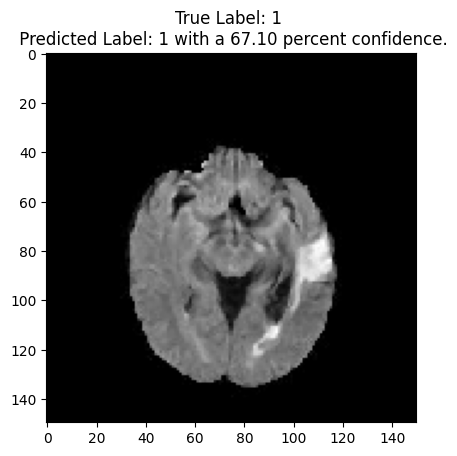

In [ ]:
for vis_image, y_true in zip(X, y):
    img = image.load_img(vis_image, target_size=(150, 150))
    x = image.img_to_array(img)
    x /= 127.5
    x = np.expand_dims(x, axis=0)
    preprocess_images = np.vstack([x])
    classes = model.predict(preprocess_images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])
    if classes[0]>0.5:
        predicted_label = 1
    else:
        predicted_label =0
    plt.title(f'True Label: {y_true} \n Predicted Label: {predicted_label} with a {100 * np.max(score):.2f} percent confidence.')
    plt.imshow(img)
    plt.show()

# <b>12.0 <span style='color:red'>|</span> What Computer see during training convolutional images </b> <a class="anchor" id="11.0"></a>

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
adult_img_files = vis_images[:5]
child_img_files = vis_images[5:10]
img_path = random.choice(adult_img_files + child_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# <b>13.0 <span style='color:red'>|</span> Test Your Own Images </b> <a class="anchor" id="13.0"></a>

Finally, you can enjoy the model prediction by using your own images.

1/1 [==============================] - 0s 198ms/step
 This image most likely belongs to '1' (With Tumor) at 69.99 percent confidence.


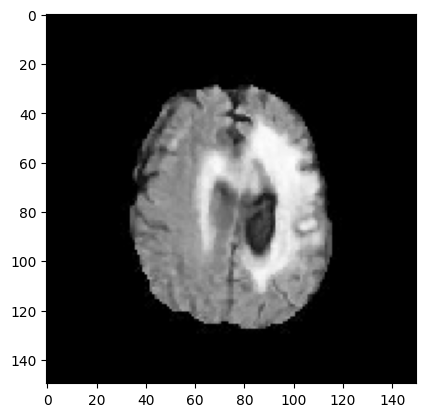

In [ ]:
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = my_dir+'/_MODELLING/testing/1/Image3702.jpg'

    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 127.5
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" This image most likely belongs to '{class_name_inverted[1]}' (With Tumor) at {100 * np.max(score):.2f} percent confidence.")
    else:
        print(f" This image most likely belongs to '{class_name_inverted[0]}' (Without Tumor) at {100 * np.max(score):.2f} percent confidence.")

make_your_prediction(YOUR_IMAGE_PATH = None)


# References
1. Deng J, Dong W, Socher R, Li L-J, Li K, Fei-Fei L. Imagenet: A large-scale hierarchical image database. In: 2009 IEEE conference on computer vision and pattern recognition. 2009. p. 248–55.